Text(0, 0.5, 'Output')

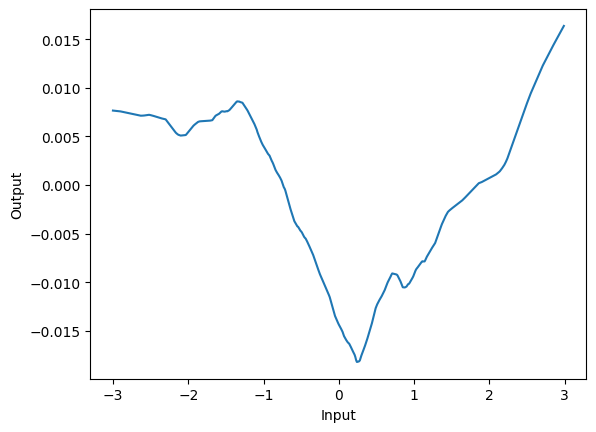

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#set random seed for reproducibility
torch.manual_seed(0)

model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

Text(0, 0.5, 'Output')

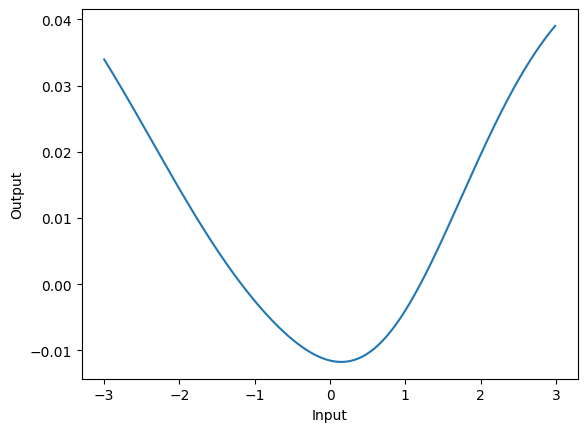

In [7]:
torch.manual_seed(0)

model = nn.Sequential(nn.Linear(1,100), nn.GELU(),
                      nn.Linear(100,100), nn.GELU(),
                      nn.Linear(100,100), nn.GELU(),
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

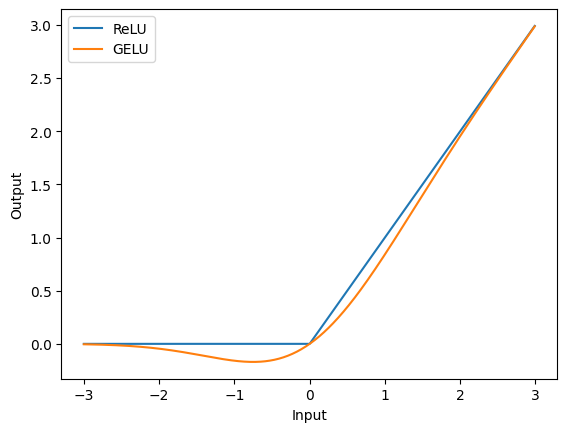

In [8]:
#plot the ReLU and GELU activation functions
plt.plot(np.arange(-3,3,0.01), nn.ReLU()(torch.tensor(np.arange(-3,3,0.01))).numpy())
plt.plot(np.arange(-3,3,0.01), nn.GELU()(torch.tensor(np.arange(-3,3,0.01))).numpy())
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend(["ReLU","GELU"])
plt.show()

